# Notebook3: Predicting CO2 emissions using Neural Networks in Design Phase

Readme: In this notebook, NN models are constructed for CO2 Emission prediction, and the best model is selected and K-means validation is applied.

- **Notebook content**:
    - Design the architecture of NN and explore different model configuration

    - Tune hyperparameters and select the best model

- **Notebook Output**:

    - Best model file

    - The validation and test results of the best model

In [2]:
# %pip install "numpy<2" torch torchvision scikit-learn
# %pip install wandb

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1 Define Plot Functions

In [4]:
# Define functions
import seaborn as sns
import torch

# 1 plot related functions----------------
# plot predict and true values on validation dataset
def plot_pred_true(y_test, y_pred, ax):

    data = pd.DataFrame({'y_obs': y_test, 'y_pred': y_pred})

    # plt.figure(figsize=(5, 5))
    sns.scatterplot(data=data, x='y_obs', y='y_pred', s=10, ax=ax)
    ax.plot(y_test, y_test, color='red', label='y=x')          # plot the line y=x
    ax.set_title('Observed vs Predicted values in Test Dataset')   # title
    ax.set_xlabel('Observed values')       # label for the x-axis
    ax.set_ylabel('Predicted values')      # label for the y-axis
    ax.legend()
    ax.grid(True)

# plot the loss value on training and validation dataset
def plot_train_val_loss(train_loss, val_loss, ax):
    
    # ax.figure(figsize=(5, 5))

    ax.plot(train_loss, label='train loss')
    ax.plot(val_loss, label='val loss')
    ax.set_title('Train vs Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

# 2 Other functions---------------------
# get the prediction and true values
def model_prediction(model, val_loader, device):

    model.eval()
    pred = []
    target = []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)      # predicted value

            pred.extend(y_pred.cpu().numpy())
            target.extend(y.cpu().numpy())

    # Merge all the predictions and targets
    predictions = np.concatenate(pred, axis=0)
    labels = np.concatenate(target, axis=0)
    return predictions, labels

## 2 Data Preparation and Feature Selection

In [5]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Load and Divide Traning and Testing Data

Load the test and train dataset

In [6]:
# Import data
trainset_df = pd.read_csv('Dataset2_train.csv')
testset_df = pd.read_csv('Dataset2_test.csv')

X_train = trainset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_train = trainset_df['CO2 Emissions(g/km)']

X_test = testset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_test = testset_df['CO2 Emissions(g/km)']


In [7]:
X_test

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,Model Features_Long wheelbase,Model Features_Short wheelbase,Vehicle Class_FULL-SIZE,Vehicle Class_MID-SIZE,...,Vehicle Class_SUBCOMPACT,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_N,Fuel Type_X,Fuel Type_Z
0,3.0,6,0,8.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,4.4,8,0,7.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,6.2,8,1,8.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5.3,8,1,6.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4.0,6,1,5.0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,2.0,4,1,9.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1473,2.0,4,1,6.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1474,1.4,4,1,6.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1475,3.5,6,1,7.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### Setup pipline for Standardisation

In [8]:
binary_columns = X_train.columns[X_train.nunique() == 2].tolist()  
numerical_columns = [col for col in X_train.columns if col not in binary_columns]

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # StandardScale
    ], 
    remainder='passthrough'  # keep dummy variable
)

# Setup pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [9]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

Inspect the processed data

In [10]:
feature_names = list(X_train) 
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Processed Train Dataset：")
print(X_train_df.head())

print("Processed Test Dataset：")
print(X_test_df.head())


Processed Train Dataset：
   Engine Size(L)  Cylinders  Gearbox_Type  Gearbox_Number  \
0       -0.121493   0.205342      0.955277             0.0   
1        0.614166   0.205342     -1.589744             0.0   
2       -0.121493   0.205342     -0.741404             0.0   
3        0.172770   0.205342      0.106937             0.0   
4       -0.857153  -0.885139      0.955277             0.0   

   Model Features_Flexible-fuel vehicle  Model Features_Four-wheel drive  \
0                                   1.0                              0.0   
1                                   1.0                              0.0   
2                                   0.0                              0.0   
3                                   0.0                              0.0   
4                                   1.0                              0.0   

   Model Features_Long wheelbase  Model Features_Short wheelbase  \
0                            0.0                             0.0   
1        

In [11]:
# Prepare the Dataloader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to Tensor
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Load the training data and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor,y_val_tensor)

# Set hyperparameters
batch_size = 64  # batch size

# Create data loader
train_Loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_Loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)



## 3 W&B Grid Search to Find Best NN Parameter Set

In [12]:
import wandb

wandb.login(key="47ea61c7ee69e2e0e1cc46ed5c31bd6168f9f9db")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\87383\_netrc
wandb: Currently logged in as: yixuan228 (yixuan228-imperial-college-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [13]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultiLayerPerceptron, self).__init__()

        # Initialise an empty list to hold layers
        layers = []

        # First layer: input to hidden
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        # Output layer: hidden to output
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [14]:
from torch.utils.data import random_split

# Calculate the sizes for train and validation splits
num_total = len(train_dataset)
num_train = int(0.9 * num_total)
num_val = num_total - num_train

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [num_train, num_val])

# Create DataLoaders for each subset
train_Loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_Loader = DataLoader(val_subset, batch_size=64, shuffle=False)

In [15]:
# Hyperparameter grid
hidden_units_options = [32, 64, 128]    # Numbers of neurons in each hidden layer
hidden_layers_options = [2, 3, 4]       # Numbers of hidden layers
learning_rates = [0.1, 0.01, 0.001]     # Learning rates

max_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
patience = 5      # Early stopping patience

input_size =  X_train_processed.shape[1]   # Input size 
output_size = 1             # Output size

learning_rate = 0.02        # Learning rate
n_epochs = 100 # Numebr of epochs

# Define the loss function and the optimizer
criterion = nn.MSELoss()    # Mean Squared Error for Linear Regression


In [16]:
# Define helper functions
# Train epoch function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    # for features, target in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
    for features, target in train_loader:
        features, target = features.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(features) # Forward pass
        loss = criterion(outputs, target)

        loss.backward()  # Backward pass
        optimizer.step() # Update the weights

        running_loss += loss.item() * features.size(0)

    return running_loss / len(train_loader.dataset)

# Validation epoch function
def val_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for features, target in val_loader:
            # print(featuresfeatures.size(0))
            features, target = features.to(device), target.to(device)
            # features = features.view(features.size(0), -1)

            outputs = model(features)
            loss = criterion(outputs, target)
            val_loss += loss.item() * features.size(0)

    return val_loss / len(val_loader.dataset)



In [17]:
from itertools import product
import torch.optim as optim

for hidden_units, hidden_layers, lr in product(hidden_units_options, hidden_layers_options, learning_rates):

    # Configurations
    config = {
        "hidden_units": hidden_units,
        "hidden_layers": hidden_layers,
        "learning_rate": lr,
        "max_epochs": max_epochs,
        "patience": patience
    }

    # Start a new W&B run for each configuration
    wandb.init(project='DE_Groupwork_G4_stage1', config=config, reinit=True)

    model = MultiLayerPerceptron(input_size=input_size, 
                             hidden_size=config["hidden_units"], 
                             num_layers=config["hidden_layers"], 
                             output_size=1).to(device)


    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    epochs_without_improvement = 0
        
    for epoch in range(1, max_epochs + 1):
        train_loss = train_epoch(model, train_Loader, criterion, optimizer, device)
       
        val_loss = val_epoch(model, val_Loader, criterion, device)

        # Log metrics to W&B
        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})
        
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    wandb.finish()

print("Training complete for all configurations.")


Epoch 001 | Train Loss: 6400.1514 | Val Loss: 938.7351
Epoch 002 | Train Loss: 788.1200 | Val Loss: 822.9958
Epoch 003 | Train Loss: 721.9565 | Val Loss: 714.7530
Epoch 004 | Train Loss: 630.5052 | Val Loss: 721.8133
Epoch 005 | Train Loss: 673.1648 | Val Loss: 650.6208
Epoch 006 | Train Loss: 620.2334 | Val Loss: 841.4749
Epoch 007 | Train Loss: 591.9293 | Val Loss: 734.0117
Epoch 008 | Train Loss: 573.2639 | Val Loss: 599.4195
Epoch 009 | Train Loss: 570.7662 | Val Loss: 1358.8709
Epoch 010 | Train Loss: 638.7929 | Val Loss: 604.4920
Epoch 011 | Train Loss: 571.9126 | Val Loss: 638.4321
Epoch 012 | Train Loss: 620.3852 | Val Loss: 588.5027
Epoch 013 | Train Loss: 602.5697 | Val Loss: 800.6641
Epoch 014 | Train Loss: 668.2451 | Val Loss: 643.2828
Epoch 015 | Train Loss: 634.3690 | Val Loss: 580.3000
Epoch 016 | Train Loss: 584.9325 | Val Loss: 549.7290
Epoch 017 | Train Loss: 538.8751 | Val Loss: 558.7020
Epoch 018 | Train Loss: 579.2524 | Val Loss: 1124.7950
Epoch 019 | Train Loss: 6

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▂▂▂▄▃▁█▁▂▁▃▂▁▁▁▆▂▂▁
epoch,21
train_loss,595.7068
val_loss,572.97729


Epoch 001 | Train Loss: 25805.9011 | Val Loss: 1734.0341
Epoch 002 | Train Loss: 1296.1157 | Val Loss: 1073.5779
Epoch 003 | Train Loss: 977.6653 | Val Loss: 912.9437
Epoch 004 | Train Loss: 829.8784 | Val Loss: 853.9524
Epoch 005 | Train Loss: 774.4765 | Val Loss: 809.3803
Epoch 006 | Train Loss: 725.5545 | Val Loss: 791.8399
Epoch 007 | Train Loss: 694.2554 | Val Loss: 772.8953
Epoch 008 | Train Loss: 675.1672 | Val Loss: 741.7608
Epoch 009 | Train Loss: 653.0527 | Val Loss: 712.3610
Epoch 010 | Train Loss: 622.1088 | Val Loss: 680.7354
Epoch 011 | Train Loss: 609.5213 | Val Loss: 677.4527
Epoch 012 | Train Loss: 599.6632 | Val Loss: 648.2716
Epoch 013 | Train Loss: 572.3549 | Val Loss: 677.0451
Epoch 014 | Train Loss: 563.6569 | Val Loss: 642.2129
Epoch 015 | Train Loss: 561.2537 | Val Loss: 658.1642
Epoch 016 | Train Loss: 555.8749 | Val Loss: 607.9476
Epoch 017 | Train Loss: 541.9991 | Val Loss: 649.5774
Epoch 018 | Train Loss: 553.3031 | Val Loss: 594.5312
Epoch 019 | Train Loss:

epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
train_loss,531.77587
val_loss,641.66445


Epoch 001 | Train Loss: 65742.8335 | Val Loss: 61937.5361
Epoch 002 | Train Loss: 53913.0334 | Val Loss: 37106.7804
Epoch 003 | Train Loss: 20032.5550 | Val Loss: 5203.3637
Epoch 004 | Train Loss: 2974.6069 | Val Loss: 2224.4583
Epoch 005 | Train Loss: 2022.1626 | Val Loss: 1892.6284
Epoch 006 | Train Loss: 1758.1798 | Val Loss: 1682.4626
Epoch 007 | Train Loss: 1588.2970 | Val Loss: 1530.2683
Epoch 008 | Train Loss: 1469.8548 | Val Loss: 1422.5030
Epoch 009 | Train Loss: 1371.9781 | Val Loss: 1328.4756
Epoch 010 | Train Loss: 1290.1482 | Val Loss: 1255.1321
Epoch 011 | Train Loss: 1216.5495 | Val Loss: 1187.3740
Epoch 012 | Train Loss: 1151.3214 | Val Loss: 1133.2032
Epoch 013 | Train Loss: 1093.0557 | Val Loss: 1078.1140
Epoch 014 | Train Loss: 1041.3206 | Val Loss: 1035.7549
Epoch 015 | Train Loss: 994.0394 | Val Loss: 998.5069
Epoch 016 | Train Loss: 954.8216 | Val Loss: 962.6513
Epoch 017 | Train Loss: 913.6998 | Val Loss: 928.9314
Epoch 018 | Train Loss: 880.0152 | Val Loss: 902.

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇██
train_loss,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,80
train_loss,551.00965
val_loss,632.58984


Epoch 001 | Train Loss: 11055.9357 | Val Loss: 1093.7884
Epoch 002 | Train Loss: 766.4498 | Val Loss: 782.1926
Epoch 003 | Train Loss: 649.8747 | Val Loss: 700.1848
Epoch 004 | Train Loss: 628.4207 | Val Loss: 749.5063
Epoch 005 | Train Loss: 616.4615 | Val Loss: 649.9108
Epoch 006 | Train Loss: 595.0415 | Val Loss: 809.4889
Epoch 007 | Train Loss: 606.5962 | Val Loss: 623.9995
Epoch 008 | Train Loss: 576.9636 | Val Loss: 637.1248
Epoch 009 | Train Loss: 567.8814 | Val Loss: 571.9735
Epoch 010 | Train Loss: 544.0545 | Val Loss: 1070.9731
Epoch 011 | Train Loss: 598.3936 | Val Loss: 838.9804
Epoch 012 | Train Loss: 564.1809 | Val Loss: 607.0254
Epoch 013 | Train Loss: 562.4973 | Val Loss: 806.1049
Epoch 014 | Train Loss: 611.3365 | Val Loss: 825.2190
Early stopping triggered at epoch 14


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▄▂▂▁█▅▁▄▄
epoch,14
train_loss,611.33651
val_loss,825.21895


Epoch 001 | Train Loss: 19791.1769 | Val Loss: 1175.7167
Epoch 002 | Train Loss: 971.5000 | Val Loss: 874.8690
Epoch 003 | Train Loss: 756.8883 | Val Loss: 789.6043
Epoch 004 | Train Loss: 696.7751 | Val Loss: 804.8944
Epoch 005 | Train Loss: 658.8203 | Val Loss: 705.5231
Epoch 006 | Train Loss: 623.3546 | Val Loss: 742.4832
Epoch 007 | Train Loss: 604.5215 | Val Loss: 668.8062
Epoch 008 | Train Loss: 584.5356 | Val Loss: 661.4459
Epoch 009 | Train Loss: 587.7532 | Val Loss: 641.0598
Epoch 010 | Train Loss: 550.1992 | Val Loss: 646.4726
Epoch 011 | Train Loss: 547.9275 | Val Loss: 597.5156
Epoch 012 | Train Loss: 547.2877 | Val Loss: 647.3616
Epoch 013 | Train Loss: 549.5983 | Val Loss: 653.3825
Epoch 014 | Train Loss: 544.5573 | Val Loss: 601.4968
Epoch 015 | Train Loss: 538.6736 | Val Loss: 789.7428
Epoch 016 | Train Loss: 544.4682 | Val Loss: 638.8145
Early stopping triggered at epoch 16


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▄▂▃▂▂▂▂▁▂▂▁▃▁
epoch,16
train_loss,544.4682
val_loss,638.8145


Epoch 001 | Train Loss: 65454.0913 | Val Loss: 58790.0187
Epoch 002 | Train Loss: 29560.9542 | Val Loss: 2367.5951
Epoch 003 | Train Loss: 1812.8269 | Val Loss: 1537.2211
Epoch 004 | Train Loss: 1422.9711 | Val Loss: 1335.7780
Epoch 005 | Train Loss: 1256.3333 | Val Loss: 1193.4689
Epoch 006 | Train Loss: 1117.5471 | Val Loss: 1079.3360
Epoch 007 | Train Loss: 1009.3032 | Val Loss: 994.0227
Epoch 008 | Train Loss: 922.8128 | Val Loss: 923.9940
Epoch 009 | Train Loss: 855.2677 | Val Loss: 880.6640
Epoch 010 | Train Loss: 805.4744 | Val Loss: 846.7848
Epoch 011 | Train Loss: 771.4908 | Val Loss: 818.2356
Epoch 012 | Train Loss: 740.0643 | Val Loss: 803.5850
Epoch 013 | Train Loss: 718.7709 | Val Loss: 794.4213
Epoch 014 | Train Loss: 701.4286 | Val Loss: 773.2249
Epoch 015 | Train Loss: 684.9716 | Val Loss: 766.0594
Epoch 016 | Train Loss: 674.5537 | Val Loss: 749.2213
Epoch 017 | Train Loss: 659.4028 | Val Loss: 741.7780
Epoch 018 | Train Loss: 649.9484 | Val Loss: 730.5281
Epoch 019 | 

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,56
train_loss,481.99047
val_loss,557.73509


Epoch 001 | Train Loss: 7303.1037 | Val Loss: 1017.5690
Epoch 002 | Train Loss: 836.3060 | Val Loss: 1208.0504
Epoch 003 | Train Loss: 737.3873 | Val Loss: 1952.0461
Epoch 004 | Train Loss: 776.4612 | Val Loss: 776.5137
Epoch 005 | Train Loss: 696.4242 | Val Loss: 781.0924
Epoch 006 | Train Loss: 618.9097 | Val Loss: 681.7795
Epoch 007 | Train Loss: 652.4450 | Val Loss: 806.9186
Epoch 008 | Train Loss: 761.5492 | Val Loss: 1191.1204
Epoch 009 | Train Loss: 776.7211 | Val Loss: 1232.8661
Epoch 010 | Train Loss: 711.5585 | Val Loss: 3063.1848
Epoch 011 | Train Loss: 1028.7895 | Val Loss: 597.9041
Epoch 012 | Train Loss: 621.3220 | Val Loss: 557.9273
Epoch 013 | Train Loss: 627.0535 | Val Loss: 748.3574
Epoch 014 | Train Loss: 600.8463 | Val Loss: 704.9598
Epoch 015 | Train Loss: 646.0717 | Val Loss: 932.7462
Epoch 016 | Train Loss: 724.7564 | Val Loss: 608.6386
Epoch 017 | Train Loss: 582.6564 | Val Loss: 549.5848
Epoch 018 | Train Loss: 576.8276 | Val Loss: 662.7330
Epoch 019 | Train Lo

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▃▅▂▂▁▂▃▃█▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁
epoch,26
train_loss,532.72921
val_loss,645.57313


Epoch 001 | Train Loss: 17733.2606 | Val Loss: 1163.0579
Epoch 002 | Train Loss: 973.8374 | Val Loss: 852.1714
Epoch 003 | Train Loss: 757.4300 | Val Loss: 801.5664
Epoch 004 | Train Loss: 682.1975 | Val Loss: 726.4545
Epoch 005 | Train Loss: 634.3383 | Val Loss: 708.2140
Epoch 006 | Train Loss: 626.6487 | Val Loss: 679.4852
Epoch 007 | Train Loss: 619.6482 | Val Loss: 814.6909
Epoch 008 | Train Loss: 609.2330 | Val Loss: 670.7982
Epoch 009 | Train Loss: 580.3370 | Val Loss: 616.8276
Epoch 010 | Train Loss: 575.4635 | Val Loss: 667.3385
Epoch 011 | Train Loss: 590.1430 | Val Loss: 642.8622
Epoch 012 | Train Loss: 564.7336 | Val Loss: 807.7882
Epoch 013 | Train Loss: 561.6162 | Val Loss: 622.3985
Epoch 014 | Train Loss: 547.0042 | Val Loss: 588.6880
Epoch 015 | Train Loss: 540.5882 | Val Loss: 585.3195
Epoch 016 | Train Loss: 541.2895 | Val Loss: 619.7738
Epoch 017 | Train Loss: 591.1838 | Val Loss: 595.2110
Epoch 018 | Train Loss: 575.0626 | Val Loss: 747.1398
Epoch 019 | Train Loss: 5

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▂▂▄▂▁▂▂▄▁▁▁▁▁▃▂▂
epoch,20
train_loss,564.34161
val_loss,707.43176


Epoch 001 | Train Loss: 65197.4451 | Val Loss: 55005.9228
Epoch 002 | Train Loss: 15877.8738 | Val Loss: 1676.8184
Epoch 003 | Train Loss: 1490.8770 | Val Loss: 1336.9108
Epoch 004 | Train Loss: 1251.0207 | Val Loss: 1155.7598
Epoch 005 | Train Loss: 1088.7153 | Val Loss: 1031.2337
Epoch 006 | Train Loss: 968.1278 | Val Loss: 939.6608
Epoch 007 | Train Loss: 875.5373 | Val Loss: 887.4313
Epoch 008 | Train Loss: 808.0279 | Val Loss: 839.5725
Epoch 009 | Train Loss: 762.9822 | Val Loss: 801.9918
Epoch 010 | Train Loss: 726.1040 | Val Loss: 774.4116
Epoch 011 | Train Loss: 696.8762 | Val Loss: 759.5111
Epoch 012 | Train Loss: 677.3556 | Val Loss: 730.9501
Epoch 013 | Train Loss: 658.6340 | Val Loss: 714.8459
Epoch 014 | Train Loss: 646.4054 | Val Loss: 702.9674
Epoch 015 | Train Loss: 627.6527 | Val Loss: 688.6334
Epoch 016 | Train Loss: 614.2640 | Val Loss: 681.9714
Epoch 017 | Train Loss: 609.6227 | Val Loss: 661.6416
Epoch 018 | Train Loss: 598.3777 | Val Loss: 656.7377
Epoch 019 | Tra

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,54
train_loss,488.20509
val_loss,546.82736


Epoch 001 | Train Loss: 5527.0864 | Val Loss: 880.7104
Epoch 002 | Train Loss: 743.1104 | Val Loss: 908.2959
Epoch 003 | Train Loss: 656.7583 | Val Loss: 715.6814
Epoch 004 | Train Loss: 646.8757 | Val Loss: 1128.3215
Epoch 005 | Train Loss: 636.8808 | Val Loss: 753.4042
Epoch 006 | Train Loss: 566.5240 | Val Loss: 619.9790
Epoch 007 | Train Loss: 645.8375 | Val Loss: 1011.3167
Epoch 008 | Train Loss: 638.3342 | Val Loss: 558.7612
Epoch 009 | Train Loss: 528.5516 | Val Loss: 703.8721
Epoch 010 | Train Loss: 606.1445 | Val Loss: 1583.4522
Epoch 011 | Train Loss: 664.6420 | Val Loss: 743.3682
Epoch 012 | Train Loss: 583.9286 | Val Loss: 1005.8444
Epoch 013 | Train Loss: 549.4928 | Val Loss: 2038.1003
Early stopping triggered at epoch 13


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▂▄▂▁▃▁▂▆▂▃█
epoch,13
train_loss,549.49284
val_loss,2038.10032


Epoch 001 | Train Loss: 16963.4958 | Val Loss: 1299.7577
Epoch 002 | Train Loss: 1063.3390 | Val Loss: 905.5655
Epoch 003 | Train Loss: 799.5400 | Val Loss: 843.3865
Epoch 004 | Train Loss: 727.6157 | Val Loss: 808.5227
Epoch 005 | Train Loss: 681.8578 | Val Loss: 753.7617
Epoch 006 | Train Loss: 646.9073 | Val Loss: 702.6051
Epoch 007 | Train Loss: 616.1694 | Val Loss: 696.8358
Epoch 008 | Train Loss: 609.8783 | Val Loss: 680.5139
Epoch 009 | Train Loss: 603.4958 | Val Loss: 665.9432
Epoch 010 | Train Loss: 587.3930 | Val Loss: 648.8157
Epoch 011 | Train Loss: 576.0097 | Val Loss: 657.1067
Epoch 012 | Train Loss: 562.8974 | Val Loss: 618.2752
Epoch 013 | Train Loss: 556.8164 | Val Loss: 630.7136
Epoch 014 | Train Loss: 557.3922 | Val Loss: 659.3486
Epoch 015 | Train Loss: 581.3554 | Val Loss: 613.7156
Epoch 016 | Train Loss: 548.6516 | Val Loss: 609.5241
Epoch 017 | Train Loss: 569.9794 | Val Loss: 600.2348
Epoch 018 | Train Loss: 548.6969 | Val Loss: 598.0490
Epoch 019 | Train Loss: 

epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁
epoch,29
train_loss,527.77862
val_loss,577.90907


Epoch 001 | Train Loss: 64165.6165 | Val Loss: 55239.5424
Epoch 002 | Train Loss: 33369.4787 | Val Loss: 7124.9248
Epoch 003 | Train Loss: 3090.6237 | Val Loss: 2106.4229
Epoch 004 | Train Loss: 1898.3204 | Val Loss: 1720.0305
Epoch 005 | Train Loss: 1621.9429 | Val Loss: 1522.3521
Epoch 006 | Train Loss: 1462.8105 | Val Loss: 1378.1717
Epoch 007 | Train Loss: 1342.5580 | Val Loss: 1278.2206
Epoch 008 | Train Loss: 1242.5156 | Val Loss: 1186.9765
Epoch 009 | Train Loss: 1156.6993 | Val Loss: 1114.2314
Epoch 010 | Train Loss: 1082.4576 | Val Loss: 1059.2877
Epoch 011 | Train Loss: 1019.2522 | Val Loss: 1007.0002
Epoch 012 | Train Loss: 966.8601 | Val Loss: 964.1745
Epoch 013 | Train Loss: 925.3187 | Val Loss: 934.2040
Epoch 014 | Train Loss: 887.2084 | Val Loss: 910.2387
Epoch 015 | Train Loss: 856.3988 | Val Loss: 885.6708
Epoch 016 | Train Loss: 830.5415 | Val Loss: 871.8722
Epoch 017 | Train Loss: 807.1327 | Val Loss: 859.6763
Epoch 018 | Train Loss: 788.4047 | Val Loss: 844.6391
Epo

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,105
train_loss,485.73734
val_loss,557.65494


Epoch 001 | Train Loss: 7402.5954 | Val Loss: 857.6537
Epoch 002 | Train Loss: 728.5779 | Val Loss: 753.8403
Epoch 003 | Train Loss: 657.5578 | Val Loss: 677.6197
Epoch 004 | Train Loss: 635.7474 | Val Loss: 1123.1386
Epoch 005 | Train Loss: 698.6332 | Val Loss: 679.5899
Epoch 006 | Train Loss: 675.0435 | Val Loss: 1936.1641
Epoch 007 | Train Loss: 825.7775 | Val Loss: 1490.0574
Epoch 008 | Train Loss: 650.0917 | Val Loss: 691.7317
Early stopping triggered at epoch 8


epoch,▁▂▃▄▅▆▇█
train_loss,█▁▁▁▁▁▁▁
val_loss,▂▁▁▃▁█▆▁
epoch,8
train_loss,650.09168
val_loss,691.73167


Epoch 001 | Train Loss: 11555.9967 | Val Loss: 985.6535
Epoch 002 | Train Loss: 857.1762 | Val Loss: 791.1553
Epoch 003 | Train Loss: 715.0366 | Val Loss: 747.2237
Epoch 004 | Train Loss: 653.6956 | Val Loss: 709.3383
Epoch 005 | Train Loss: 629.8101 | Val Loss: 686.3943
Epoch 006 | Train Loss: 586.5740 | Val Loss: 655.0634
Epoch 007 | Train Loss: 576.4055 | Val Loss: 650.5212
Epoch 008 | Train Loss: 585.3923 | Val Loss: 727.0276
Epoch 009 | Train Loss: 561.1823 | Val Loss: 678.5637
Epoch 010 | Train Loss: 555.6391 | Val Loss: 594.3059
Epoch 011 | Train Loss: 566.6542 | Val Loss: 729.3568
Epoch 012 | Train Loss: 588.1497 | Val Loss: 602.4029
Epoch 013 | Train Loss: 553.0832 | Val Loss: 575.6824
Epoch 014 | Train Loss: 527.6142 | Val Loss: 654.4383
Epoch 015 | Train Loss: 555.8211 | Val Loss: 701.4411
Epoch 016 | Train Loss: 575.5996 | Val Loss: 661.0919
Epoch 017 | Train Loss: 546.1393 | Val Loss: 645.9300
Epoch 018 | Train Loss: 538.0103 | Val Loss: 574.6264
Epoch 019 | Train Loss: 54

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▄▃▁▄▂▁▂▃▃▂▁▂▂▁▁▁▃▂▂
epoch,26
train_loss,511.00785
val_loss,650.54714


Epoch 001 | Train Loss: 58562.2623 | Val Loss: 25663.1248
Epoch 002 | Train Loss: 4819.9292 | Val Loss: 1752.0405
Epoch 003 | Train Loss: 1525.9470 | Val Loss: 1359.8101
Epoch 004 | Train Loss: 1268.9531 | Val Loss: 1166.9154
Epoch 005 | Train Loss: 1106.1073 | Val Loss: 1035.3788
Epoch 006 | Train Loss: 984.2832 | Val Loss: 953.9918
Epoch 007 | Train Loss: 897.1821 | Val Loss: 895.1645
Epoch 008 | Train Loss: 834.1626 | Val Loss: 865.7964
Epoch 009 | Train Loss: 794.4157 | Val Loss: 830.0470
Epoch 010 | Train Loss: 759.0138 | Val Loss: 807.0603
Epoch 011 | Train Loss: 728.8702 | Val Loss: 788.2949
Epoch 012 | Train Loss: 714.6778 | Val Loss: 782.6969
Epoch 013 | Train Loss: 697.2416 | Val Loss: 787.6135
Epoch 014 | Train Loss: 687.4657 | Val Loss: 758.3501
Epoch 015 | Train Loss: 668.8119 | Val Loss: 735.8577
Epoch 016 | Train Loss: 656.4936 | Val Loss: 729.7576
Epoch 017 | Train Loss: 645.3048 | Val Loss: 722.6585
Epoch 018 | Train Loss: 638.7501 | Val Loss: 711.3893
Epoch 019 | Trai

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,56
train_loss,509.76802
val_loss,583.29444


Epoch 001 | Train Loss: 3533.3922 | Val Loss: 680.8681
Epoch 002 | Train Loss: 879.6107 | Val Loss: 2700.0400
Epoch 003 | Train Loss: 1407.6213 | Val Loss: 905.7014
Epoch 004 | Train Loss: 821.4566 | Val Loss: 2673.0364
Epoch 005 | Train Loss: 885.8539 | Val Loss: 794.3462
Epoch 006 | Train Loss: 714.3164 | Val Loss: 684.2078
Early stopping triggered at epoch 6


epoch,▁▂▄▅▇█
train_loss,█▁▃▁▁▁
val_loss,▁█▂█▁▁
epoch,6
train_loss,714.3164
val_loss,684.20778


Epoch 001 | Train Loss: 10735.4925 | Val Loss: 897.4151
Epoch 002 | Train Loss: 793.2929 | Val Loss: 774.9200
Epoch 003 | Train Loss: 670.1779 | Val Loss: 716.4139
Epoch 004 | Train Loss: 624.1702 | Val Loss: 637.6144
Epoch 005 | Train Loss: 615.2859 | Val Loss: 701.6970
Epoch 006 | Train Loss: 619.1596 | Val Loss: 854.8325
Epoch 007 | Train Loss: 597.3589 | Val Loss: 661.3420
Epoch 008 | Train Loss: 560.9256 | Val Loss: 727.4256
Epoch 009 | Train Loss: 604.5453 | Val Loss: 815.1314
Early stopping triggered at epoch 9


epoch,▁▂▃▄▅▅▆▇█
train_loss,█▁▁▁▁▁▁▁▁
val_loss,█▅▃▁▃▇▂▃▆
epoch,9
train_loss,604.54526
val_loss,815.13136


Epoch 001 | Train Loss: 49319.9122 | Val Loss: 6342.2379
Epoch 002 | Train Loss: 2053.2833 | Val Loss: 1369.4275
Epoch 003 | Train Loss: 1219.6105 | Val Loss: 1066.9377
Epoch 004 | Train Loss: 983.0248 | Val Loss: 918.5970
Epoch 005 | Train Loss: 838.0703 | Val Loss: 850.9394
Epoch 006 | Train Loss: 757.7394 | Val Loss: 775.9631
Epoch 007 | Train Loss: 698.6391 | Val Loss: 746.0013
Epoch 008 | Train Loss: 662.9451 | Val Loss: 718.1499
Epoch 009 | Train Loss: 633.5875 | Val Loss: 715.5630
Epoch 010 | Train Loss: 616.3531 | Val Loss: 673.2895
Epoch 011 | Train Loss: 606.7462 | Val Loss: 659.7153
Epoch 012 | Train Loss: 586.2784 | Val Loss: 654.1524
Epoch 013 | Train Loss: 573.1356 | Val Loss: 641.6476
Epoch 014 | Train Loss: 562.0853 | Val Loss: 624.5111
Epoch 015 | Train Loss: 552.3287 | Val Loss: 623.3495
Epoch 016 | Train Loss: 543.0877 | Val Loss: 602.5094
Epoch 017 | Train Loss: 533.3019 | Val Loss: 595.7130
Epoch 018 | Train Loss: 529.0207 | Val Loss: 585.8926
Epoch 019 | Train Los

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,43
train_loss,470.30501
val_loss,538.10965


Epoch 001 | Train Loss: 4765.4316 | Val Loss: 865.6560
Epoch 002 | Train Loss: 755.3500 | Val Loss: 671.9341
Epoch 003 | Train Loss: 658.1545 | Val Loss: 672.7114
Epoch 004 | Train Loss: 605.5266 | Val Loss: 1130.9108
Epoch 005 | Train Loss: 761.6313 | Val Loss: 1306.4834
Epoch 006 | Train Loss: 705.2608 | Val Loss: 906.2095
Epoch 007 | Train Loss: 656.9692 | Val Loss: 592.2935
Epoch 008 | Train Loss: 641.6400 | Val Loss: 916.9997
Epoch 009 | Train Loss: 664.4256 | Val Loss: 645.5973
Epoch 010 | Train Loss: 571.0002 | Val Loss: 584.2552
Epoch 011 | Train Loss: 755.0861 | Val Loss: 638.2414
Epoch 012 | Train Loss: 655.0381 | Val Loss: 1376.3698
Epoch 013 | Train Loss: 768.3359 | Val Loss: 711.1675
Epoch 014 | Train Loss: 566.9047 | Val Loss: 878.9126
Epoch 015 | Train Loss: 590.0145 | Val Loss: 561.9457
Epoch 016 | Train Loss: 576.2378 | Val Loss: 680.7037
Epoch 017 | Train Loss: 504.5040 | Val Loss: 565.3118
Epoch 018 | Train Loss: 513.1802 | Val Loss: 554.7802
Epoch 019 | Train Loss: 

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_loss,▄▂▃▆▇▄▂▄▂▂▂█▃▄▂▃▂▂▃▃▃▃▁▆▆▂▁▁▁▂▄▂▂
epoch,33
train_loss,500.79526
val_loss,641.78604


Epoch 001 | Train Loss: 12867.0356 | Val Loss: 1100.8885
Epoch 002 | Train Loss: 918.4357 | Val Loss: 855.0411
Epoch 003 | Train Loss: 739.1802 | Val Loss: 850.9149
Epoch 004 | Train Loss: 682.1244 | Val Loss: 730.4219
Epoch 005 | Train Loss: 632.0605 | Val Loss: 672.9893
Epoch 006 | Train Loss: 612.7728 | Val Loss: 657.7487
Epoch 007 | Train Loss: 576.1564 | Val Loss: 637.8978
Epoch 008 | Train Loss: 556.8736 | Val Loss: 662.7297
Epoch 009 | Train Loss: 556.0231 | Val Loss: 614.8959
Epoch 010 | Train Loss: 553.9799 | Val Loss: 604.5350
Epoch 011 | Train Loss: 541.8407 | Val Loss: 673.3338
Epoch 012 | Train Loss: 565.6091 | Val Loss: 598.1990
Epoch 013 | Train Loss: 552.5011 | Val Loss: 649.3222
Epoch 014 | Train Loss: 554.0663 | Val Loss: 761.1756
Epoch 015 | Train Loss: 537.9115 | Val Loss: 580.6674
Epoch 016 | Train Loss: 522.5667 | Val Loss: 597.3358
Epoch 017 | Train Loss: 529.0217 | Val Loss: 575.0742
Epoch 018 | Train Loss: 527.4100 | Val Loss: 600.9608
Epoch 019 | Train Loss: 5

epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▃▃▂▂▂▂▂▃▂▂▄▁▂▁▂▁▁▁▂▂▁
epoch,24
train_loss,529.15086
val_loss,573.7674


Epoch 001 | Train Loss: 59446.5779 | Val Loss: 36328.4996
Epoch 002 | Train Loss: 10304.0294 | Val Loss: 1989.2543
Epoch 003 | Train Loss: 1709.3969 | Val Loss: 1512.7876
Epoch 004 | Train Loss: 1420.3063 | Val Loss: 1314.5235
Epoch 005 | Train Loss: 1247.8319 | Val Loss: 1180.6242
Epoch 006 | Train Loss: 1118.0839 | Val Loss: 1070.4864
Epoch 007 | Train Loss: 1015.2280 | Val Loss: 985.8794
Epoch 008 | Train Loss: 934.5731 | Val Loss: 940.8011
Epoch 009 | Train Loss: 876.2932 | Val Loss: 890.1275
Epoch 010 | Train Loss: 829.0919 | Val Loss: 860.1036
Epoch 011 | Train Loss: 791.4222 | Val Loss: 839.0410
Epoch 012 | Train Loss: 764.1687 | Val Loss: 821.9374
Epoch 013 | Train Loss: 744.2640 | Val Loss: 802.3843
Epoch 014 | Train Loss: 724.9554 | Val Loss: 792.9550
Epoch 015 | Train Loss: 709.8006 | Val Loss: 776.0161
Epoch 016 | Train Loss: 699.5033 | Val Loss: 770.2752
Epoch 017 | Train Loss: 684.9274 | Val Loss: 761.2332
Epoch 018 | Train Loss: 673.9500 | Val Loss: 749.7987
Epoch 019 | 

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,64
train_loss,514.79547
val_loss,589.19231


Epoch 001 | Train Loss: 22092.5366 | Val Loss: 1037.6314
Epoch 002 | Train Loss: 876.2458 | Val Loss: 697.0676
Epoch 003 | Train Loss: 724.8906 | Val Loss: 825.0037
Epoch 004 | Train Loss: 708.2910 | Val Loss: 694.5977
Epoch 005 | Train Loss: 662.7341 | Val Loss: 635.3805
Epoch 006 | Train Loss: 646.6937 | Val Loss: 663.1023
Epoch 007 | Train Loss: 622.0669 | Val Loss: 657.1431
Epoch 008 | Train Loss: 632.9385 | Val Loss: 1732.8842
Epoch 009 | Train Loss: 602.9602 | Val Loss: 969.5597
Epoch 010 | Train Loss: 626.4815 | Val Loss: 672.1543
Early stopping triggered at epoch 10


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▄▁▂▁▁▁▁█▃▁
epoch,10
train_loss,626.48153
val_loss,672.15429


Epoch 001 | Train Loss: 8856.4257 | Val Loss: 960.2631
Epoch 002 | Train Loss: 747.8551 | Val Loss: 751.3390
Epoch 003 | Train Loss: 652.4110 | Val Loss: 652.9783
Epoch 004 | Train Loss: 591.1315 | Val Loss: 724.5408
Epoch 005 | Train Loss: 560.2228 | Val Loss: 591.0663
Epoch 006 | Train Loss: 559.4128 | Val Loss: 709.7193
Epoch 007 | Train Loss: 550.7284 | Val Loss: 674.8612
Epoch 008 | Train Loss: 527.1415 | Val Loss: 569.6531
Epoch 009 | Train Loss: 538.8166 | Val Loss: 699.0940
Epoch 010 | Train Loss: 534.2687 | Val Loss: 576.6620
Epoch 011 | Train Loss: 540.3896 | Val Loss: 553.7115
Epoch 012 | Train Loss: 576.3764 | Val Loss: 825.3467
Epoch 013 | Train Loss: 572.1770 | Val Loss: 939.8119
Epoch 014 | Train Loss: 525.0861 | Val Loss: 826.1319
Epoch 015 | Train Loss: 556.7018 | Val Loss: 568.1536
Epoch 016 | Train Loss: 503.1798 | Val Loss: 668.6745
Early stopping triggered at epoch 16


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▄▂▄▃▁▄▁▁▆█▆▁▃
epoch,16
train_loss,503.17981
val_loss,668.67448


Epoch 001 | Train Loss: 39950.6313 | Val Loss: 1981.9906
Epoch 002 | Train Loss: 1525.7337 | Val Loss: 1229.2707
Epoch 003 | Train Loss: 1103.5387 | Val Loss: 992.2645
Epoch 004 | Train Loss: 906.4663 | Val Loss: 876.5039
Epoch 005 | Train Loss: 801.8440 | Val Loss: 815.7283
Epoch 006 | Train Loss: 733.8013 | Val Loss: 769.2275
Epoch 007 | Train Loss: 687.9854 | Val Loss: 750.3626
Epoch 008 | Train Loss: 660.9278 | Val Loss: 723.0200
Epoch 009 | Train Loss: 634.0601 | Val Loss: 709.5909
Epoch 010 | Train Loss: 612.3297 | Val Loss: 695.8482
Epoch 011 | Train Loss: 592.6444 | Val Loss: 658.8145
Epoch 012 | Train Loss: 582.7191 | Val Loss: 642.8218
Epoch 013 | Train Loss: 568.0112 | Val Loss: 631.0552
Epoch 014 | Train Loss: 552.7987 | Val Loss: 620.0131
Epoch 015 | Train Loss: 539.5968 | Val Loss: 605.1519
Epoch 016 | Train Loss: 532.5556 | Val Loss: 601.9132
Epoch 017 | Train Loss: 521.1131 | Val Loss: 583.8199
Epoch 018 | Train Loss: 521.2875 | Val Loss: 582.3956
Epoch 019 | Train Loss

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,41
train_loss,466.26343
val_loss,516.57457


Epoch 001 | Train Loss: 14610.5140 | Val Loss: 1468.4104
Epoch 002 | Train Loss: 820.2098 | Val Loss: 873.4616
Epoch 003 | Train Loss: 750.1533 | Val Loss: 1309.6780
Epoch 004 | Train Loss: 612.2961 | Val Loss: 572.8515
Epoch 005 | Train Loss: 553.8270 | Val Loss: 568.4287
Epoch 006 | Train Loss: 541.0117 | Val Loss: 581.3662
Epoch 007 | Train Loss: 744.6960 | Val Loss: 873.9552
Epoch 008 | Train Loss: 544.1771 | Val Loss: 557.6293
Epoch 009 | Train Loss: 544.6777 | Val Loss: 594.3294
Epoch 010 | Train Loss: 612.4522 | Val Loss: 633.6293
Epoch 011 | Train Loss: 492.0607 | Val Loss: 792.4695
Epoch 012 | Train Loss: 608.2906 | Val Loss: 597.9687
Epoch 013 | Train Loss: 587.6228 | Val Loss: 861.5123
Early stopping triggered at epoch 13


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▇▁▁▁▃▁▁▂▃▁▃
epoch,13
train_loss,587.62279
val_loss,861.51229


Epoch 001 | Train Loss: 8233.7840 | Val Loss: 883.4865
Epoch 002 | Train Loss: 738.3696 | Val Loss: 863.5943
Epoch 003 | Train Loss: 653.9065 | Val Loss: 663.6584
Epoch 004 | Train Loss: 651.8443 | Val Loss: 635.8780
Epoch 005 | Train Loss: 550.8949 | Val Loss: 779.2313
Epoch 006 | Train Loss: 613.2379 | Val Loss: 557.5862
Epoch 007 | Train Loss: 519.0568 | Val Loss: 675.1102
Epoch 008 | Train Loss: 569.7691 | Val Loss: 550.7154
Epoch 009 | Train Loss: 633.3032 | Val Loss: 717.9604
Epoch 010 | Train Loss: 663.5494 | Val Loss: 614.6419
Epoch 011 | Train Loss: 576.0694 | Val Loss: 510.8799
Epoch 012 | Train Loss: 537.4515 | Val Loss: 2171.3943
Epoch 013 | Train Loss: 598.3126 | Val Loss: 509.8925
Epoch 014 | Train Loss: 528.1657 | Val Loss: 513.4237
Epoch 015 | Train Loss: 483.6986 | Val Loss: 652.8787
Epoch 016 | Train Loss: 489.0377 | Val Loss: 555.7426
Epoch 017 | Train Loss: 481.1776 | Val Loss: 781.4253
Epoch 018 | Train Loss: 576.0644 | Val Loss: 519.8757
Early stopping triggered a

epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▂▂▂▁▂▁▂▁▁█▁▁▂▁▂▁
epoch,18
train_loss,576.06437
val_loss,519.87574


Epoch 001 | Train Loss: 32314.8924 | Val Loss: 1760.8592
Epoch 002 | Train Loss: 1247.3624 | Val Loss: 1027.6200
Epoch 003 | Train Loss: 915.6032 | Val Loss: 855.5558
Epoch 004 | Train Loss: 769.7672 | Val Loss: 788.8835
Epoch 005 | Train Loss: 695.7646 | Val Loss: 735.1503
Epoch 006 | Train Loss: 659.5577 | Val Loss: 704.4936
Epoch 007 | Train Loss: 622.9921 | Val Loss: 695.4691
Epoch 008 | Train Loss: 602.9774 | Val Loss: 658.7093
Epoch 009 | Train Loss: 585.7243 | Val Loss: 641.4650
Epoch 010 | Train Loss: 565.2314 | Val Loss: 646.0564
Epoch 011 | Train Loss: 553.7483 | Val Loss: 660.4575
Epoch 012 | Train Loss: 529.8454 | Val Loss: 603.0649
Epoch 013 | Train Loss: 521.4603 | Val Loss: 599.2321
Epoch 014 | Train Loss: 510.6683 | Val Loss: 638.6949
Epoch 015 | Train Loss: 503.1981 | Val Loss: 575.0780
Epoch 016 | Train Loss: 495.1181 | Val Loss: 568.1937
Epoch 017 | Train Loss: 483.8572 | Val Loss: 560.1058
Epoch 018 | Train Loss: 477.2654 | Val Loss: 533.4540
Epoch 019 | Train Loss:

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▄▅▄▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▂▂▄▁▃▁▁▂▁▁▁▁▁▁▁▁
epoch,52
train_loss,397.98443
val_loss,462.20385


Training complete for all configurations.


Visualization of each Search

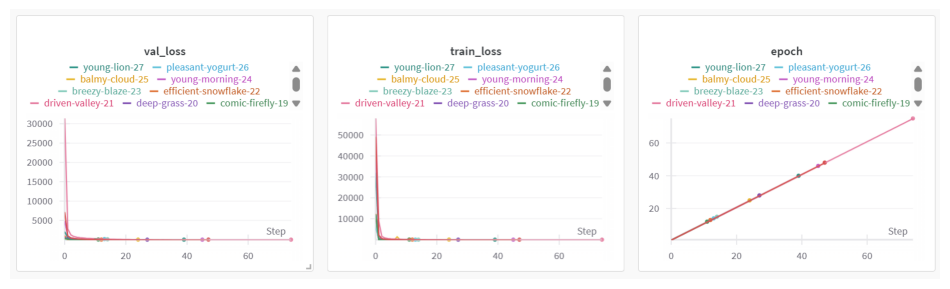

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "S1_NN_loss.png"
img = mpimg.imread(image_path)

plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [19]:
import wandb
import os

api = wandb.Api()

project_path = "yixuan228-imperial-college-london/DE_Groupwork G4"
runs = api.runs(project_path)  # Get all the runs

# save_dir = "wandb_artifacts"
# os.makedirs(save_dir, exist_ok=True)

### Save all the model config

In [20]:
ls_summary, ls_config = [], []

best_run = None
best_val_loss = float('inf')

ls_config = [run.config for run in runs]
ls_summary = [run.summary._json_dict for run in runs]


In [21]:
import wandb
import torch

wandb.init(project='DE_Groupwork_G4_stage1')

# 获取所有 runs
api = wandb.Api()
runs = api.runs("DE_Groupwork_G4_stage1")

# 找到最优模型（根据最低 val_loss）
best_run = min(runs, key=lambda run: run.summary.get("best_val_loss", float("inf")))




### Select the best model

In [22]:
best_run = None
best_loss = float("inf")  

for run in runs:
    # print(run.summary.keys())
    if "val_loss" in run.summary:  
        loss = run.summary["val_loss"]
        if loss < best_loss:  # best model with least loss
            best_loss = loss
            best_run = run

# Best model hyparparameters
if best_run:
    print("\nBest Model Found:")
    print(f"Run ID: {best_run.id}, Name: {best_run.name}, State: {best_run.state}")
    print(f"Lowest Validation Loss: {best_loss}")

    print("\nBest Model Hyperparameters (config):")
    for key, value in best_run.config.items():
        print(f"   {key}: {value}")

    print("\nBest Model Final Metrics (summary):")
    for key, value in best_run.summary.items():
        print(f"   {key}: {value}")
else:
    print("No valid runs found with 'loss' metric.")




Best Model Found:
Run ID: rpnohgzb, Name: summer-oath-56, State: finished
Lowest Validation Loss: 462.2038497537526

Best Model Hyperparameters (config):
   patience: 5
   max_epochs: 200
   hidden_units: 128
   hidden_layers: 4
   learning_rate: 0.001

Best Model Final Metrics (summary):
   _runtime: 32.3245175
   _step: 51
   _timestamp: 1742479625.7614367
   _wandb: {'runtime': 32}
   epoch: 52
   train_loss: 397.9844270268172
   val_loss: 462.2038497537526


In [23]:
# 下载最优模型
best_model_path = "best_model.pth"
best_run.file(best_model_path).download(replace=True)

# 加载模型
model = MultiLayerPerceptron(input_size=input_size,
                             hidden_size=best_run.config["hidden_units"],
                             num_layers=best_run.config["hidden_layers"],
                             output_size=1).to(device)
model.load_state_dict(torch.load(best_model_path))

wandb.finish()

print("Best model loaded successfully!")

CommError: HTTP 404: file rpnohgzb/best_model.pth not found while downloading file

## Conclusion

Using Nueral Network Models is a good way to predict the CO2 emssions based on the features given. After using W&B to grid search the hyperparameters grid, the best model is chosen based on the metric of validation loss.

The best model parameters are listed below:

**Hyperparameter**:\
    patience: 5\
    max_epochs: 200\
    hidden_units: 64\
    hidden_layers: 2\
    learning_rate: 0.001

**Running Performance:**\
    epoch: 118\
    Training loss: 8.823451982218003\
    Validation loss: 8.600484386515094




## Best Model Using K-fold Validation 